In [1]:
# Pendulum
# Continuous Control input
# Actor Critic structure, with tensorflow
# using TD-error not Q learning as Advantage
# Advantage for Actor update

# Hope it works

import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

n_observation = 3
n_action = 1
n_hidden_c = 10
n_hidden_a = 10

# Critic Network used to estimate state value function v
tf_obs_c = tf.placeholder(tf.float32, [None, n_observation])
# layers
W1_c = tf.Variable(tf.random_normal([n_observation, n_hidden_c], stddev=0.1))
b1_c = tf.Variable(tf.random_normal([n_hidden_c]))
W2_c = tf.Variable(tf.random_normal([n_hidden_c, 1], stddev=0.1))
b2_c = tf.Variable(tf.random_normal([1]))
    
fc1_c = tf.nn.relu(tf.matmul(tf_obs_c, W1_c) + b1_c)
tf_v = tf.reduce_sum(tf.matmul(fc1_c, W2_c) + b2_c)

# training
tf_target_v = tf.placeholder(tf.float32, [None, 1])
loss_c = tf.reduce_sum(tf.square(tf_target_v - tf_v))
trainer_c = tf.train.AdamOptimizer(0.001).minimize(loss_c)

# Actor Network
tf_obs_a = tf.placeholder(tf.float32, [None, n_observation])
# layers
W1_a = tf.Variable(tf.random_normal([n_observation, n_hidden_a], stddev=0.1))
b1_a = tf.Variable(tf.random_normal([n_hidden_a]))
W2_a = tf.Variable(tf.random_normal([n_hidden_a, n_action], stddev=0.1))
b2_a = tf.Variable(tf.random_normal([n_action]))
    
fc1_a = tf.nn.relu(tf.matmul(tf_obs_a, W1_a) + b1_a)
out_a = tf.matmul(fc1_a, W2_a) + b2_a
tf_mu = tf.nn.tanh(out_a) * 2

# normal distribution
tf_action = tf.placeholder(tf.float32)
tf_advantage = tf.placeholder(tf.float32)
sigma = 0.3
normal_distrib = tf.contrib.distributions.Normal(tf_mu, sigma)
tf_out_action = tf.squeeze(normal_distrib.sample([1]))
tf_log_prob = normal_distrib.log_prob(tf_action)


# td_error, advantge as the direction
loss_a = -tf_log_prob * tf_advantage
trainer_a = tf.train.AdamOptimizer(0.001).minimize(loss_a)

def saturation(action, amp):
    action = amp if action > amp else action
    action = -amp if action < -amp else action
    return action

[2017-07-14 14:07:56,212] Making new env: Pendulum-v0


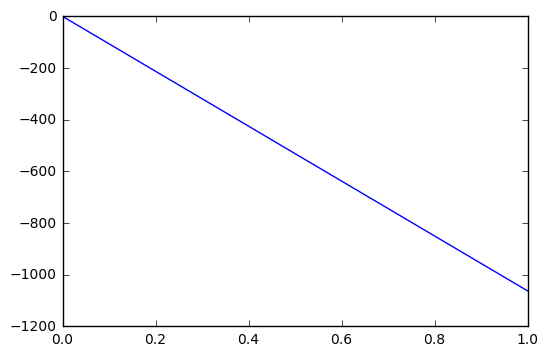

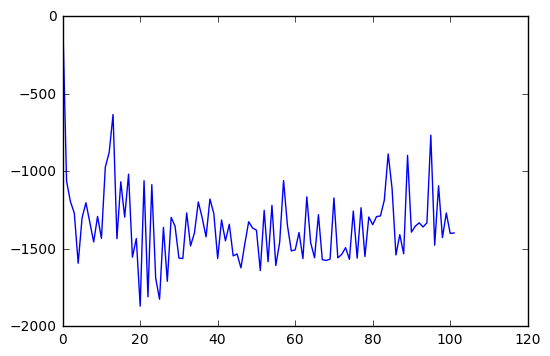

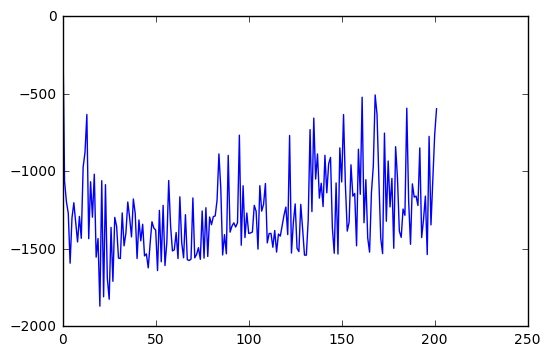

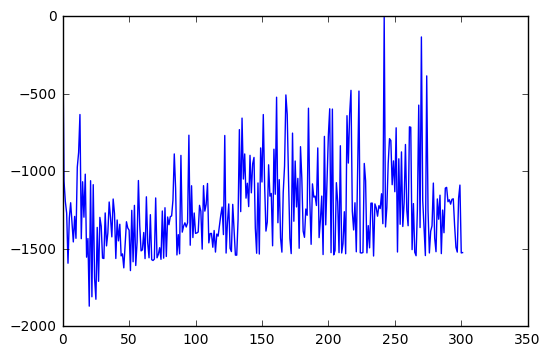

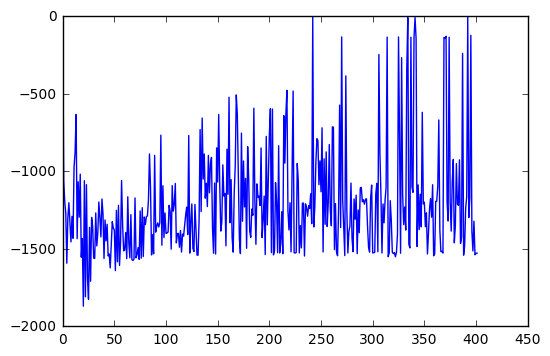

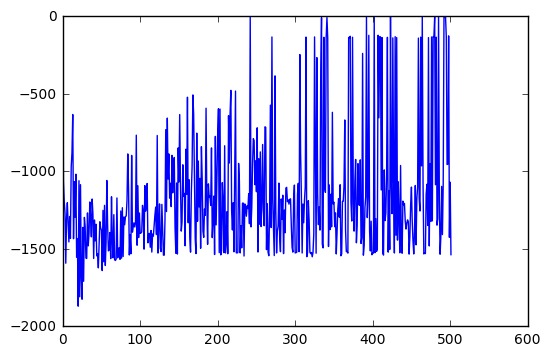

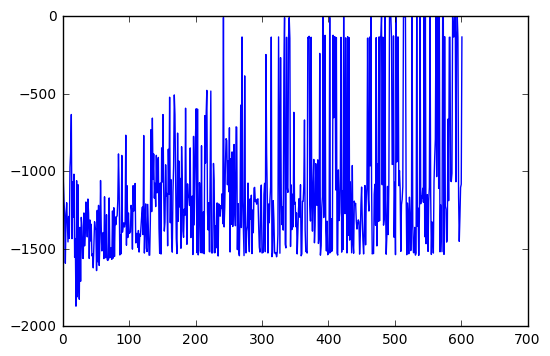

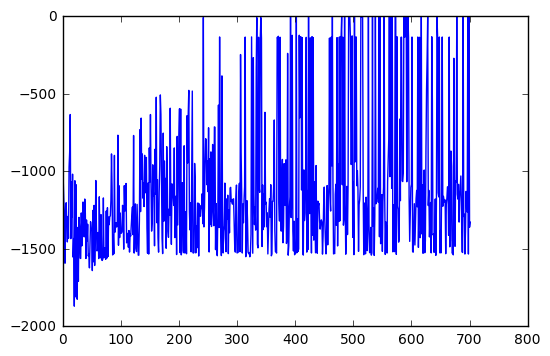

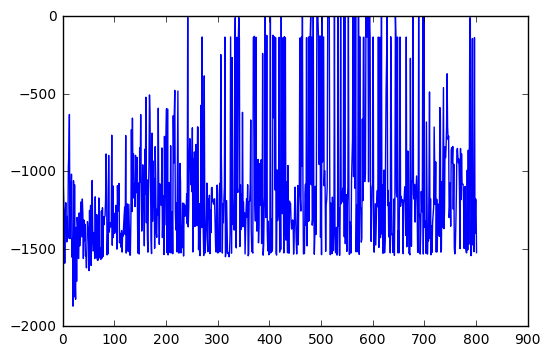

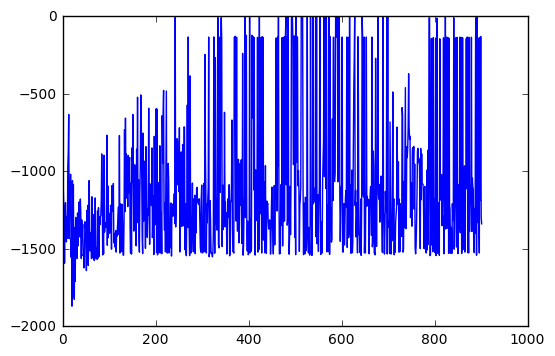

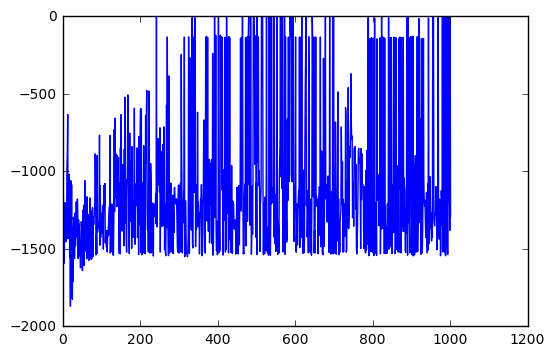

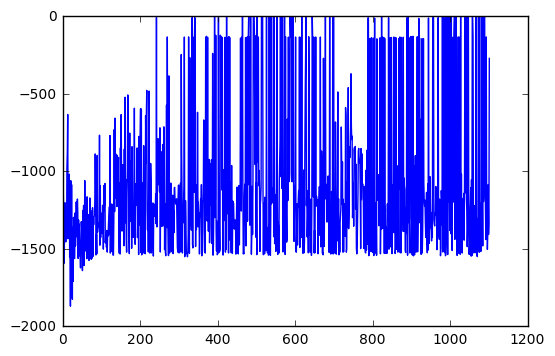

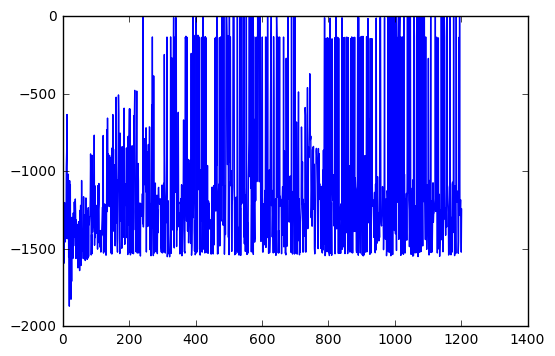

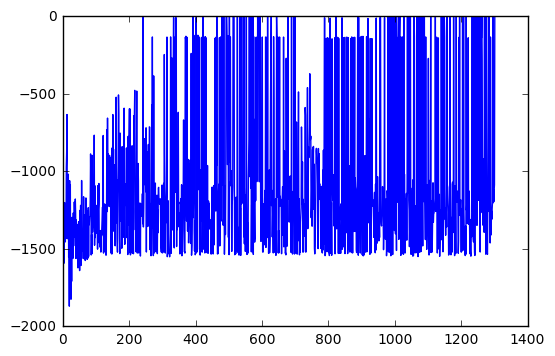

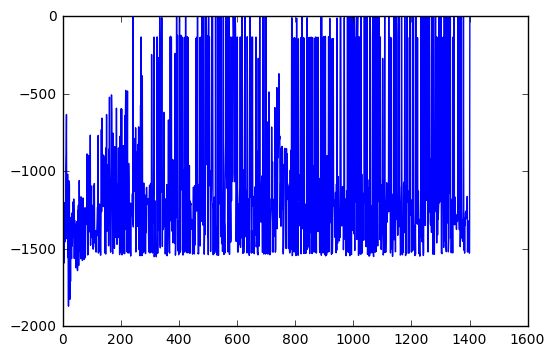

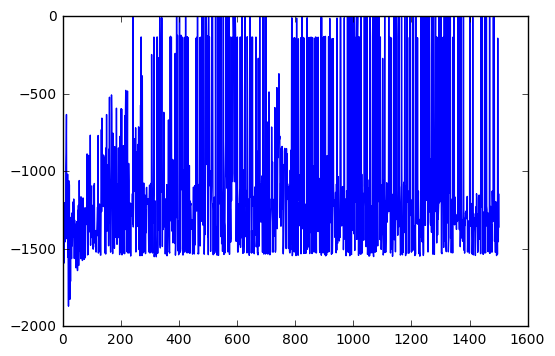

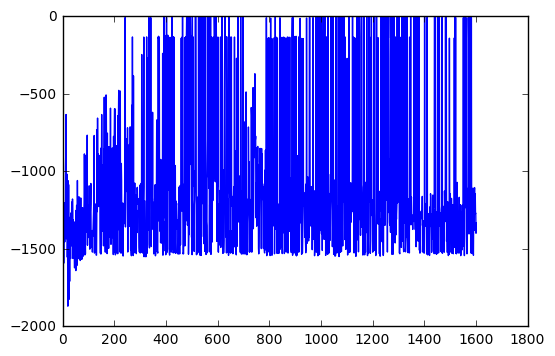

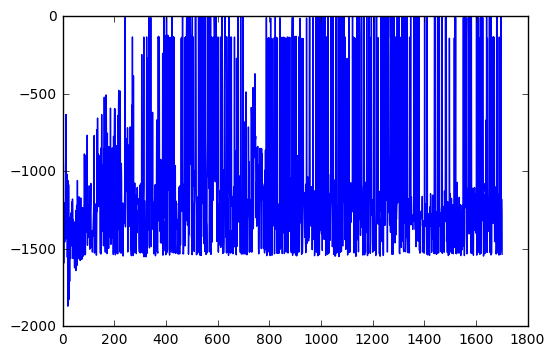

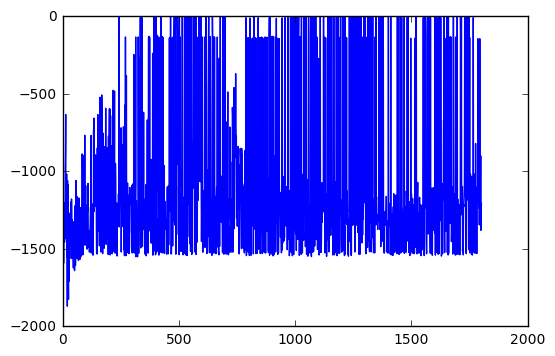

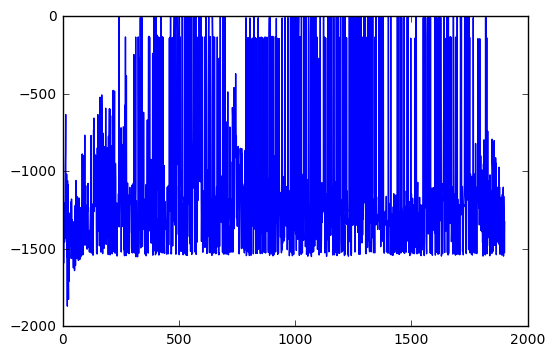

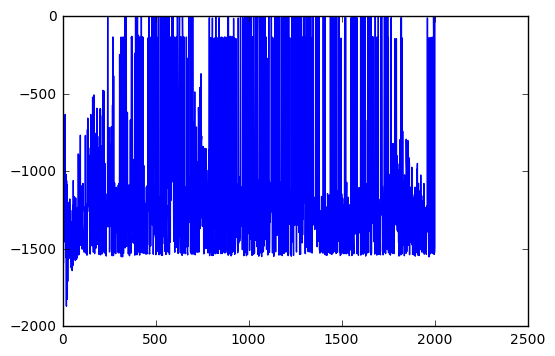

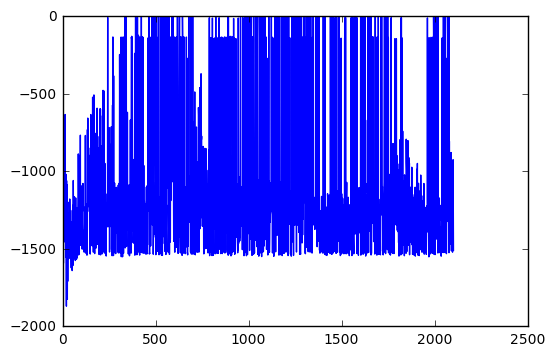

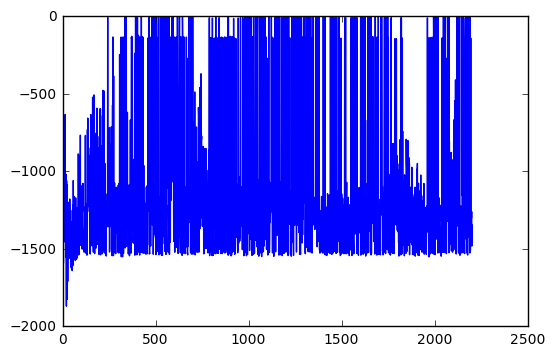

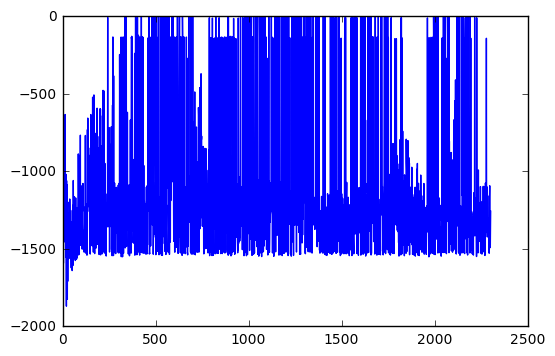

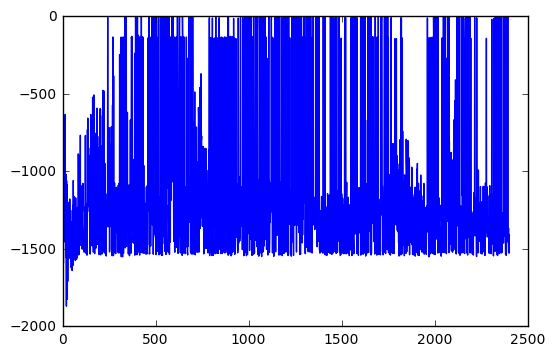

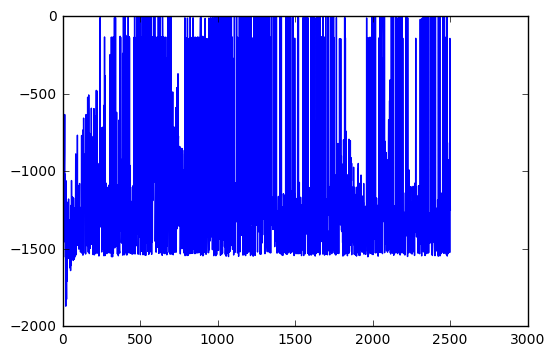

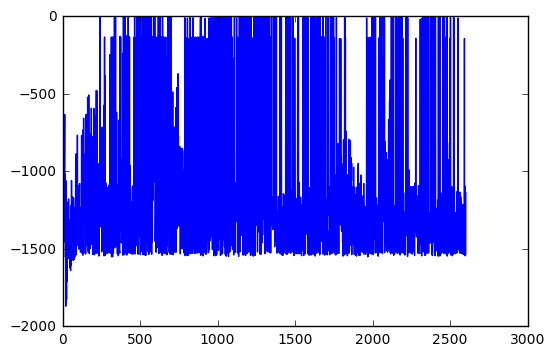

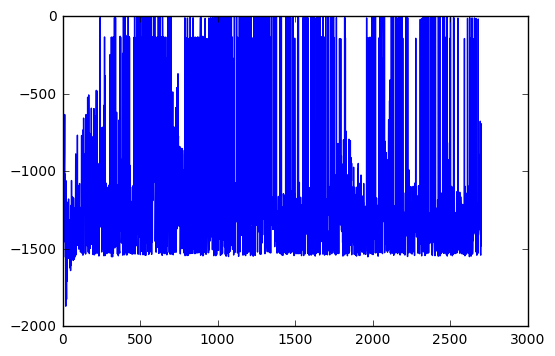

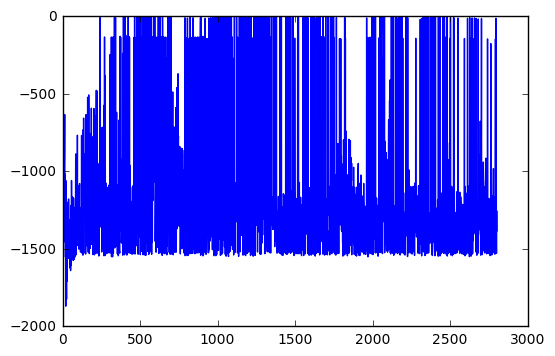

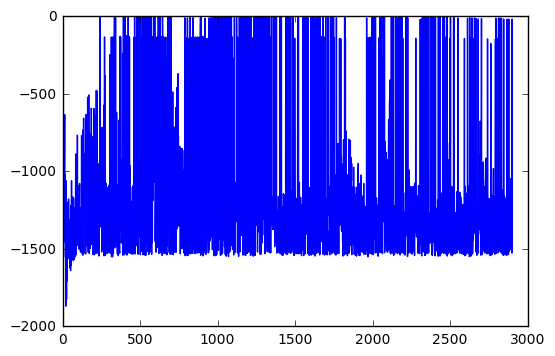

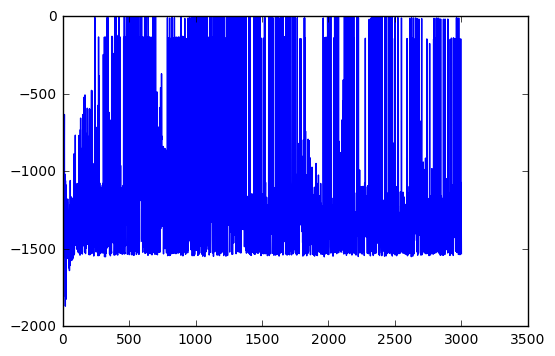

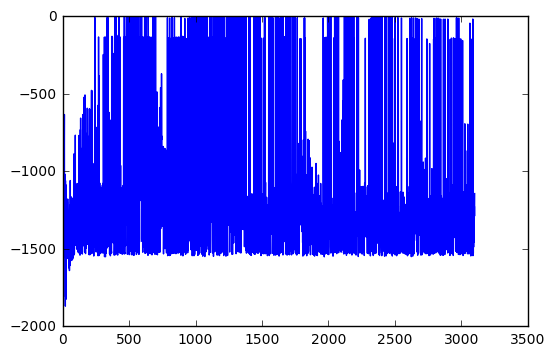

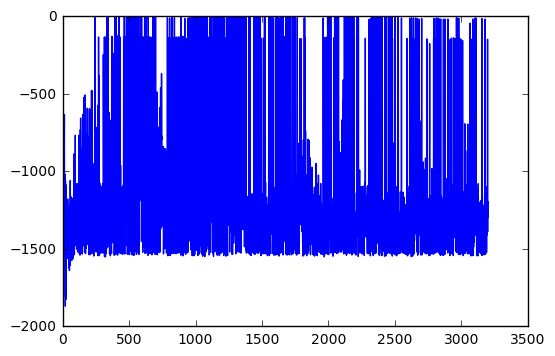

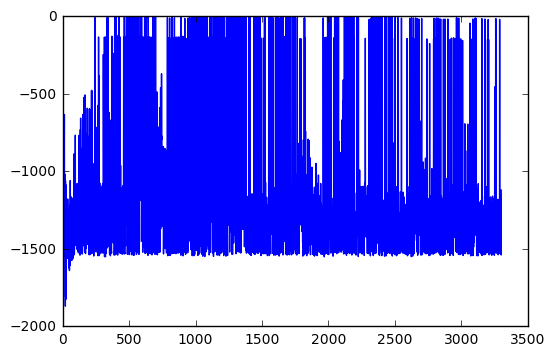

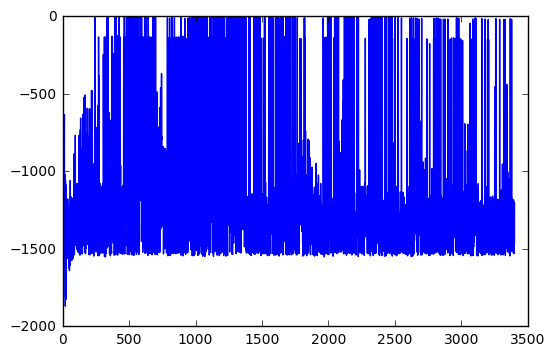

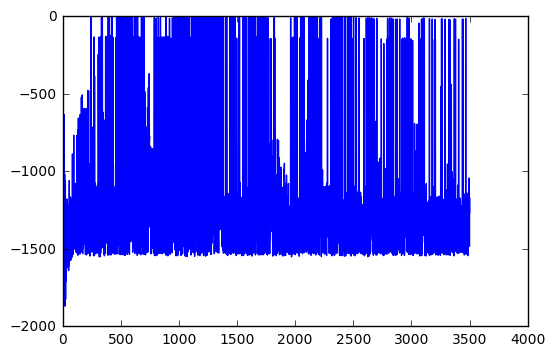

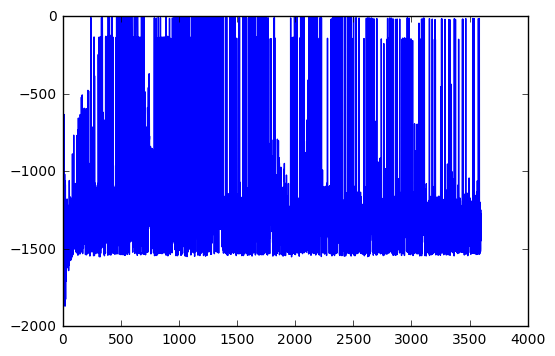

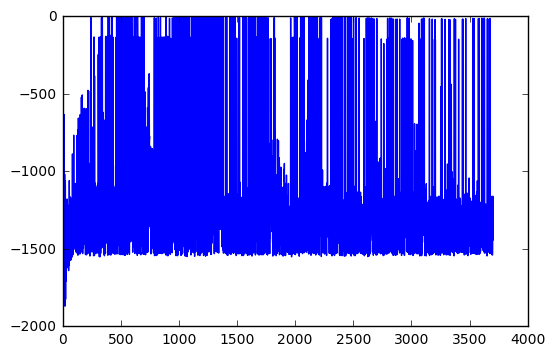

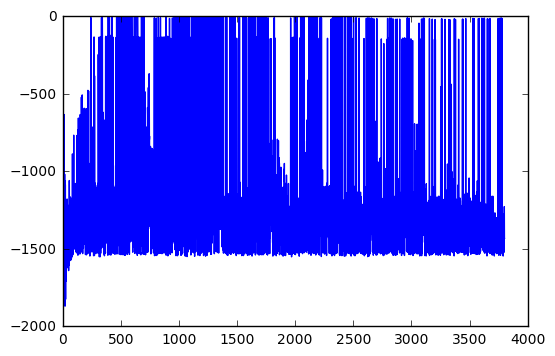

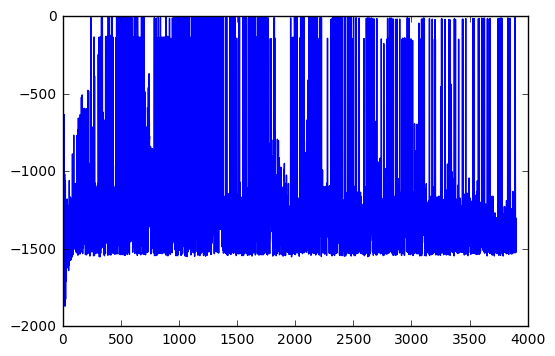

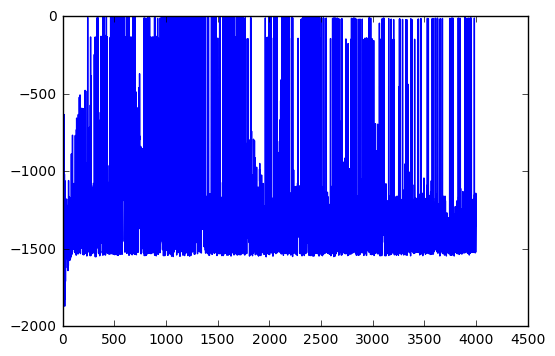

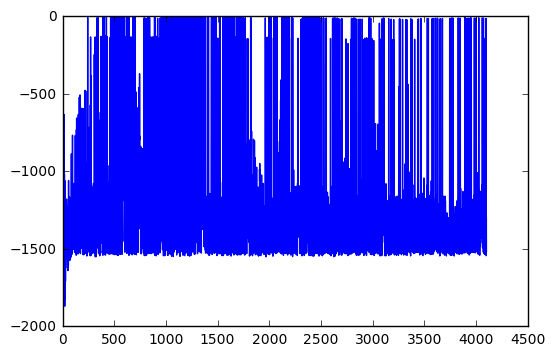

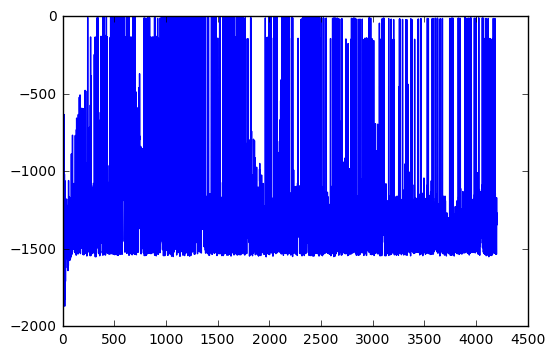

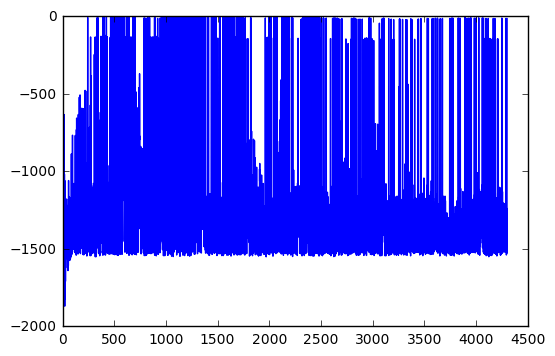

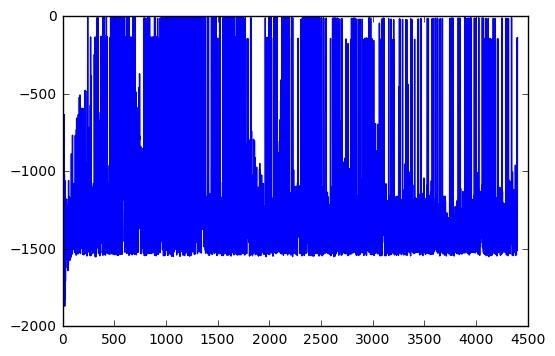

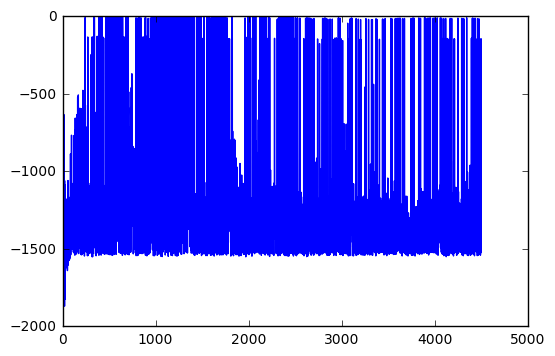

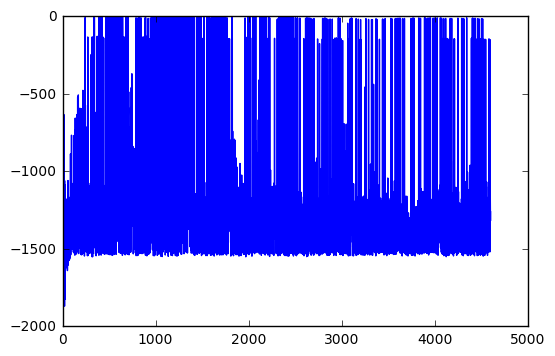

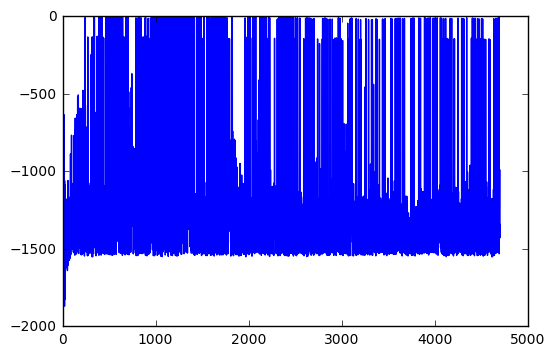

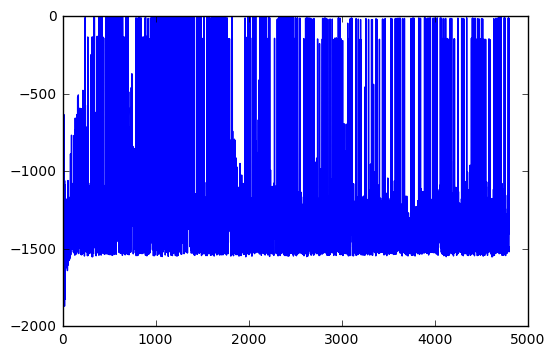

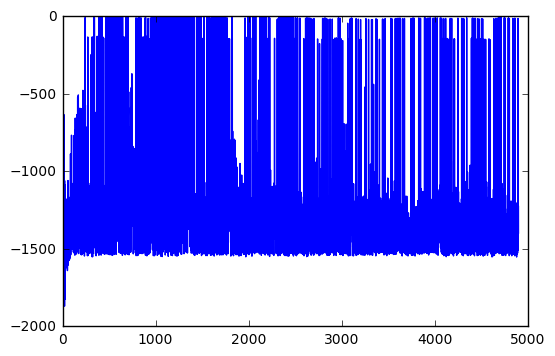

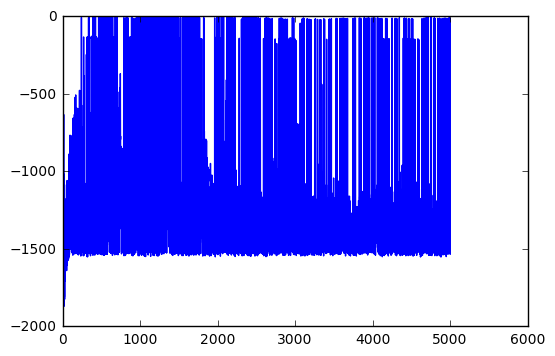

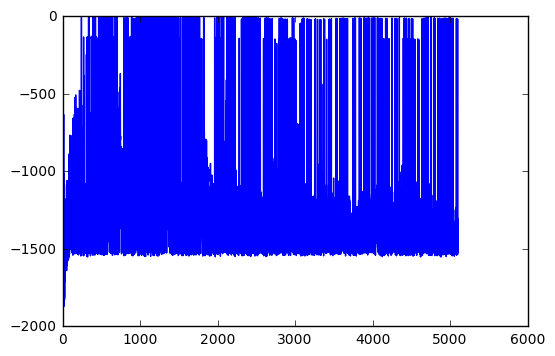

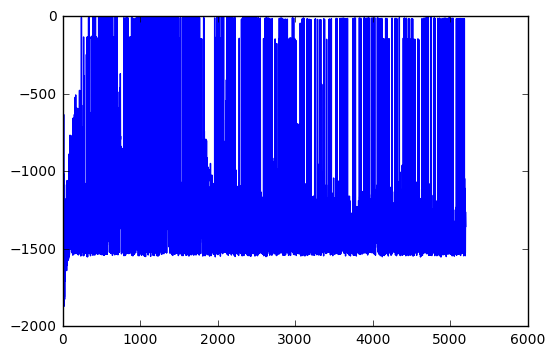

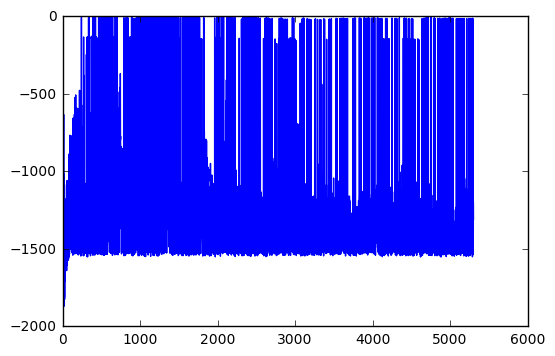

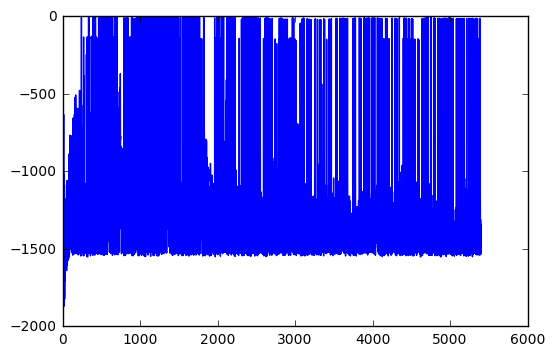

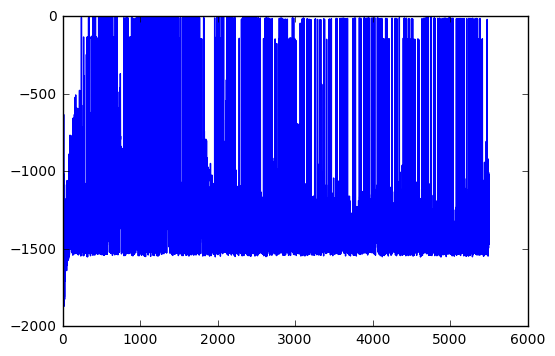

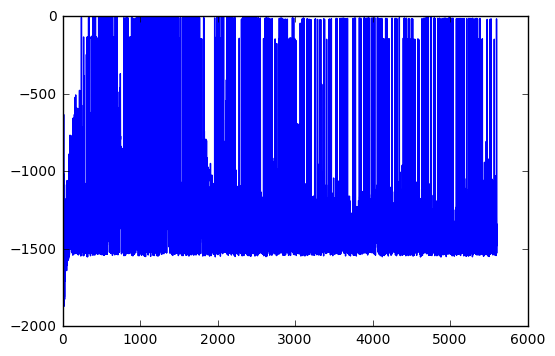

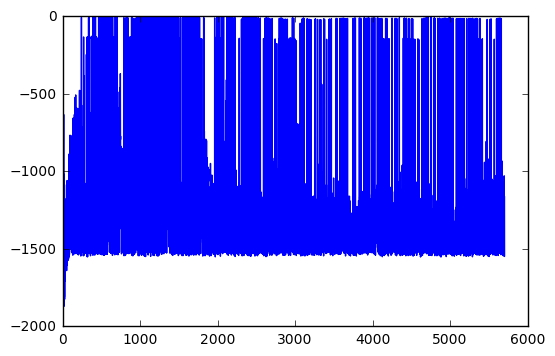

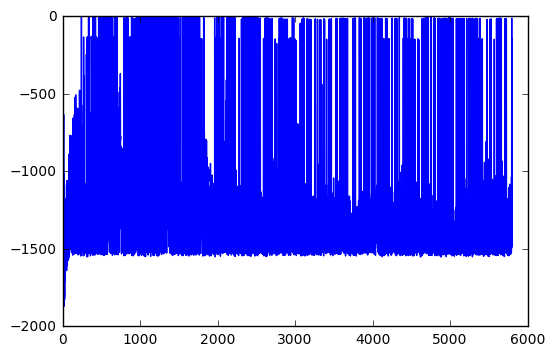

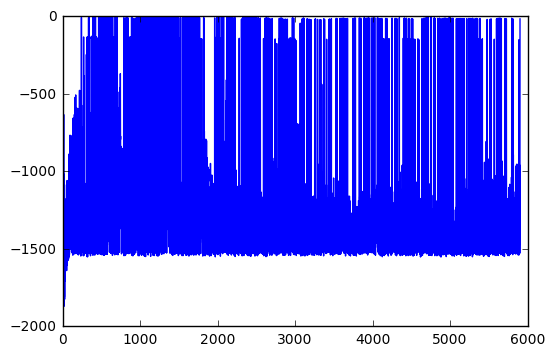

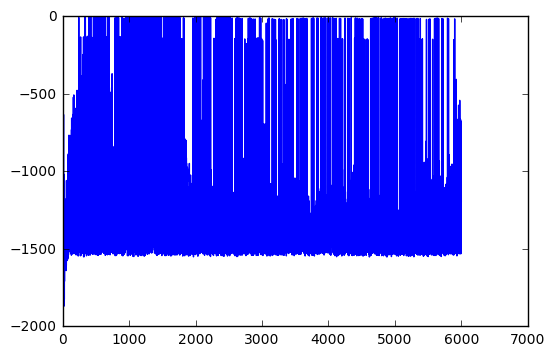

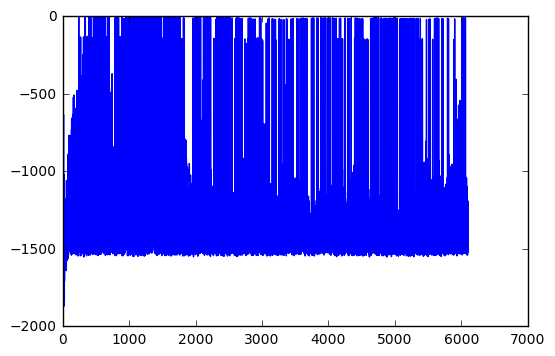

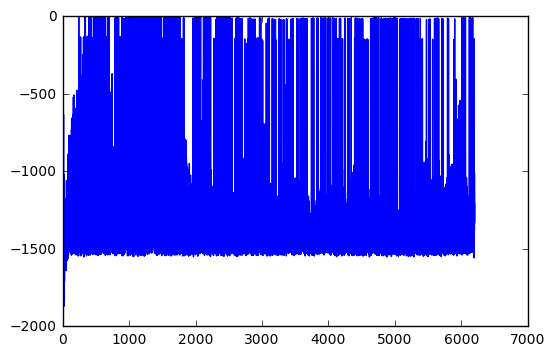

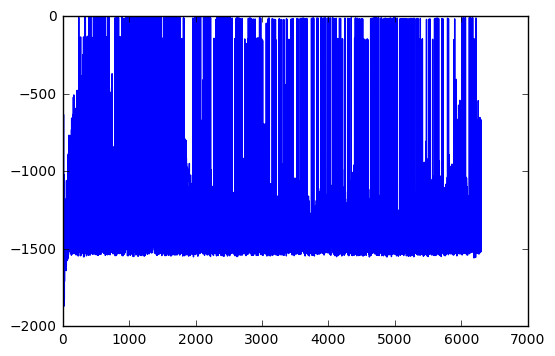

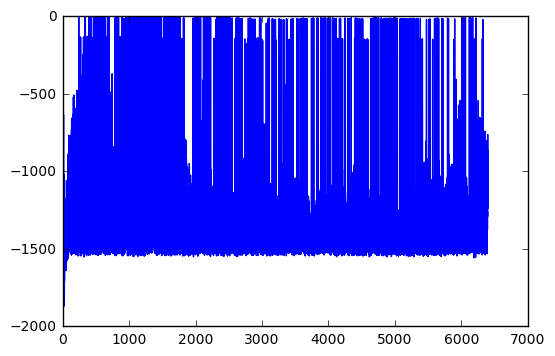

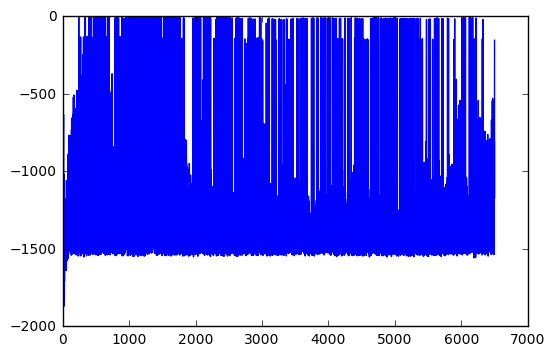

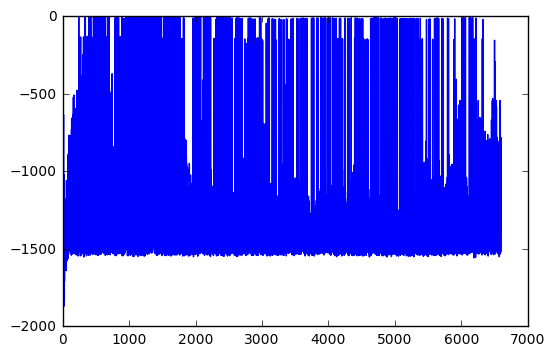

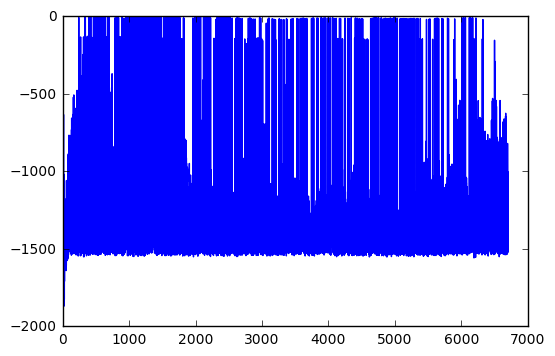

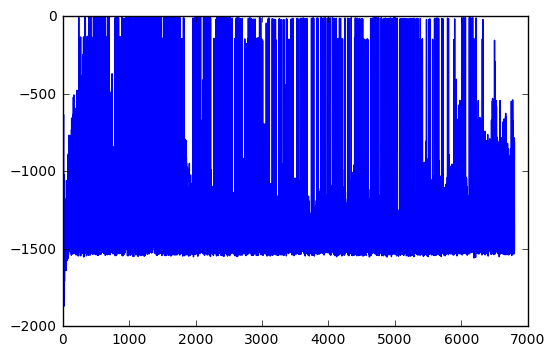

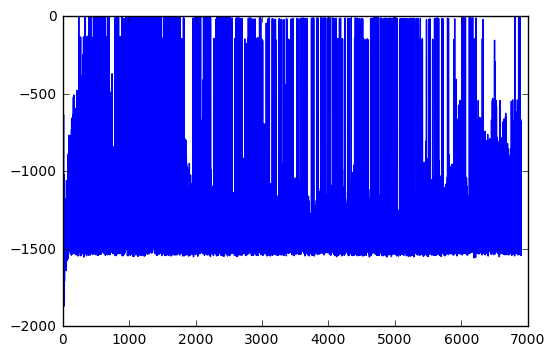

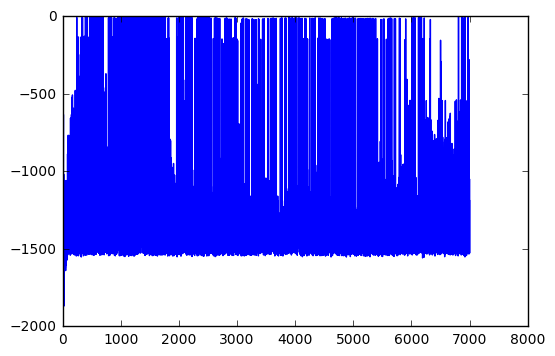

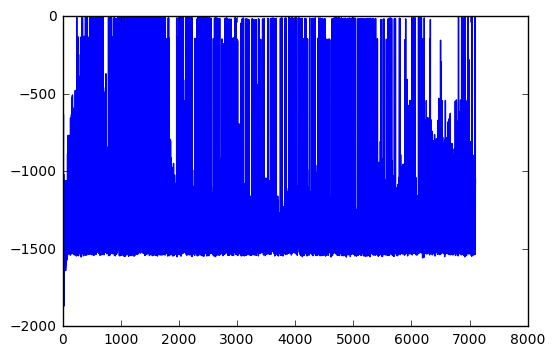

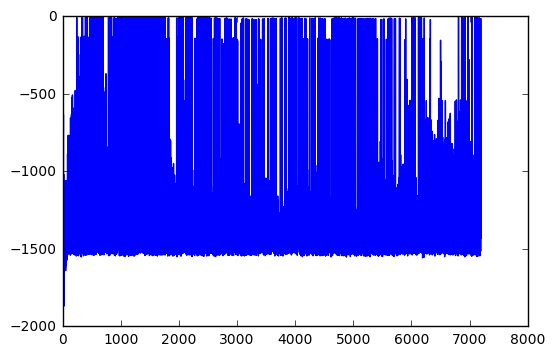

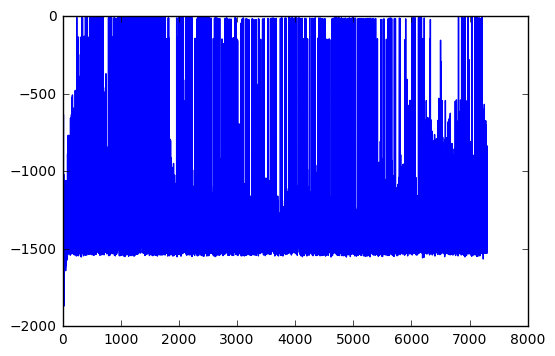

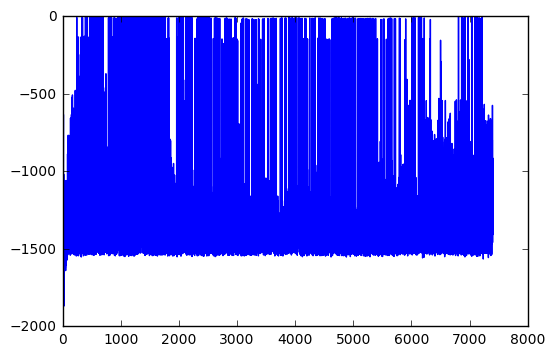

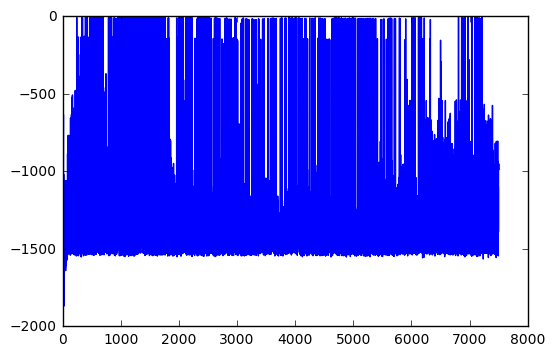

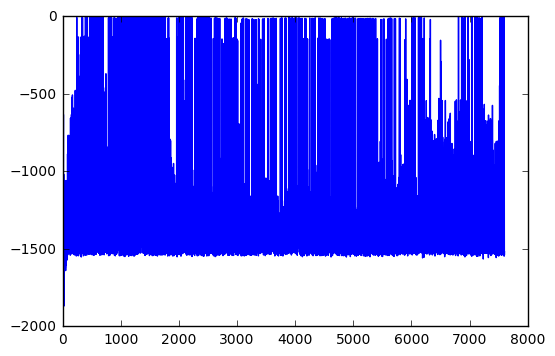

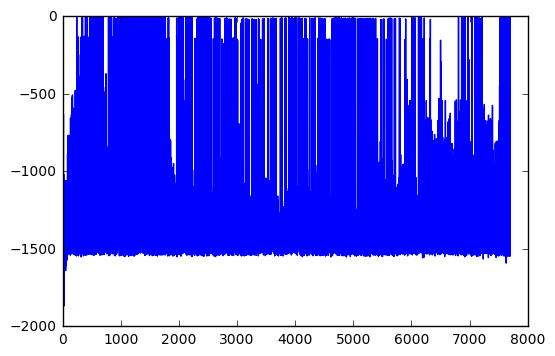

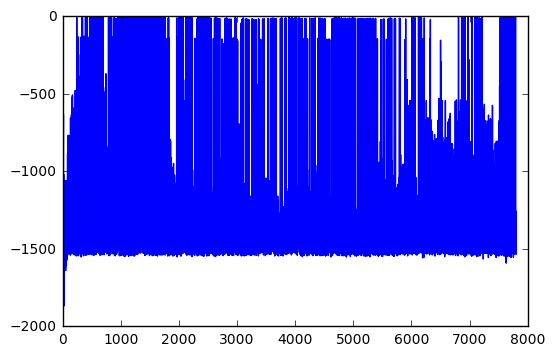

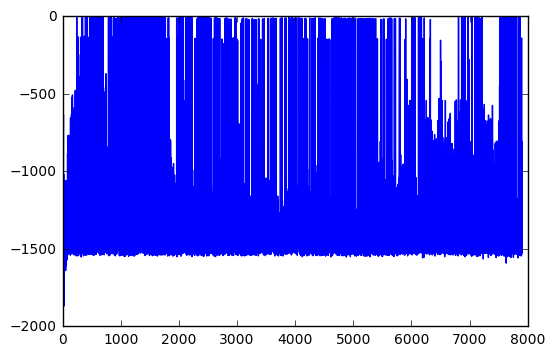

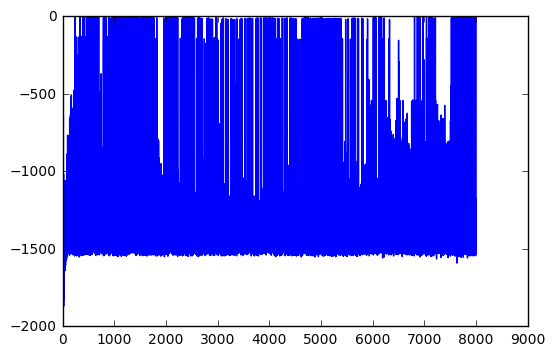

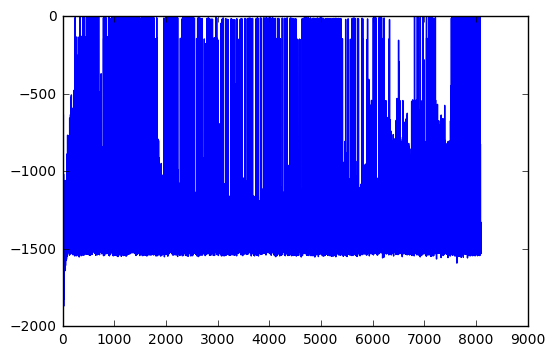

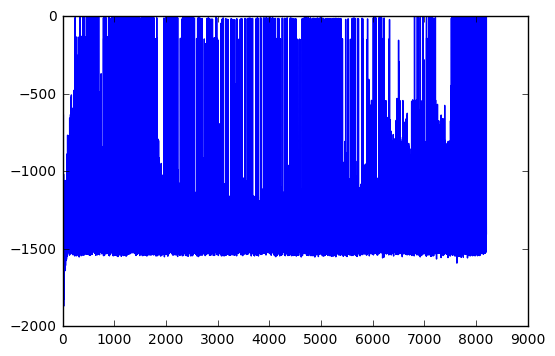

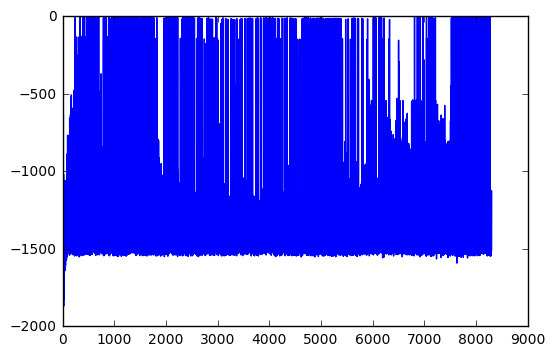

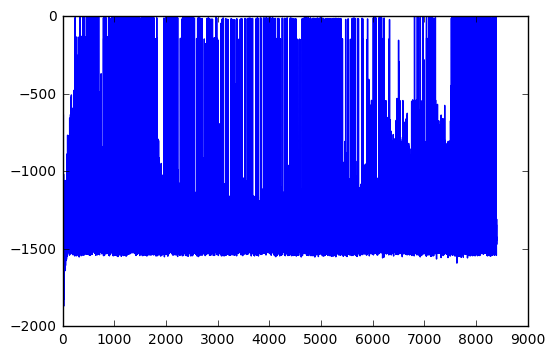

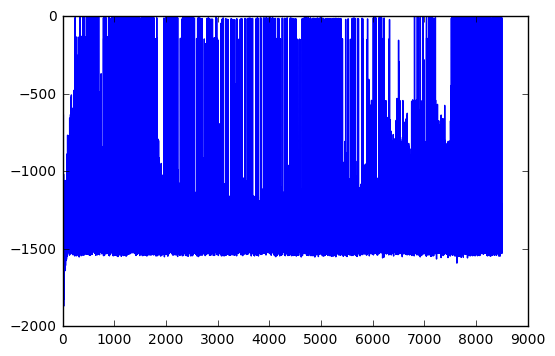

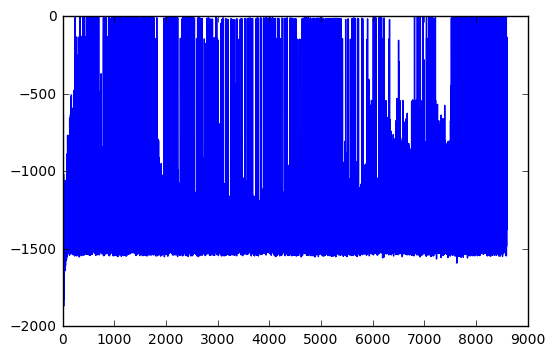

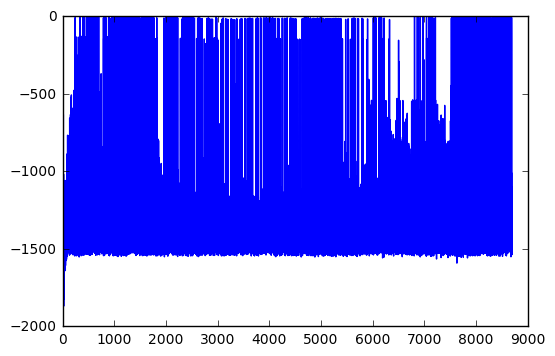

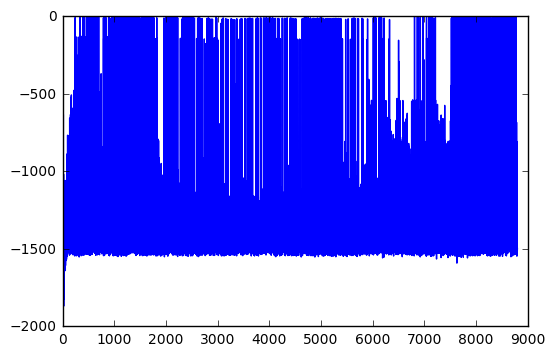

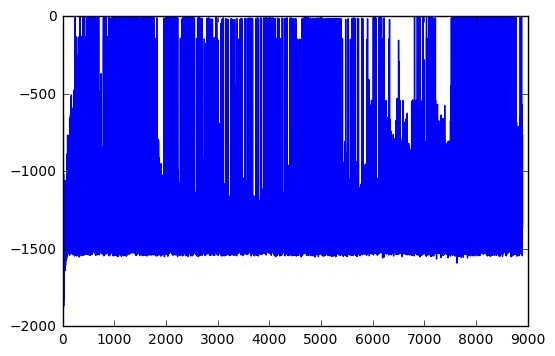

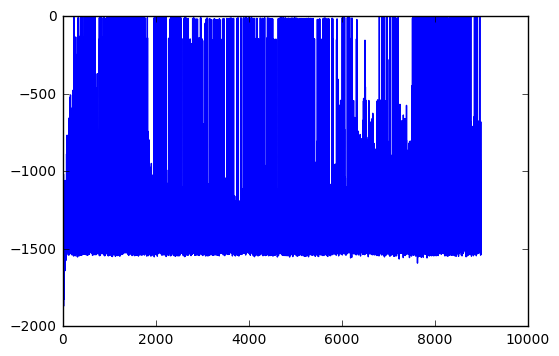

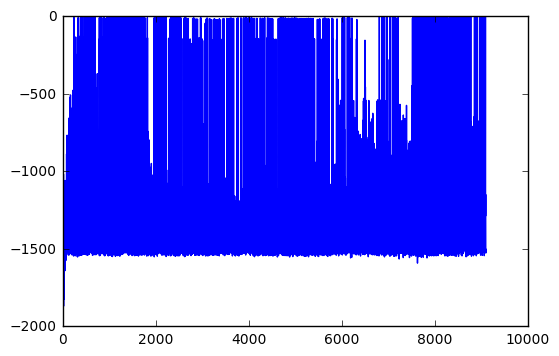

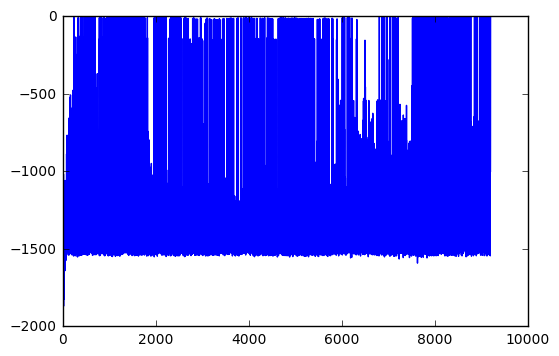

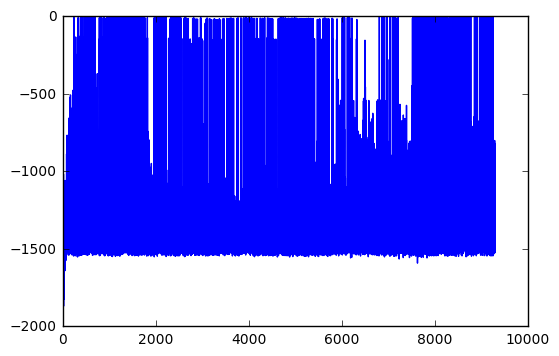

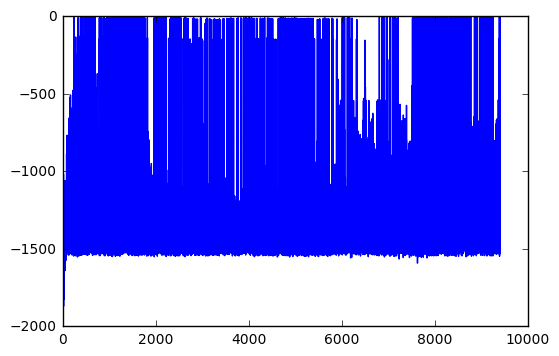

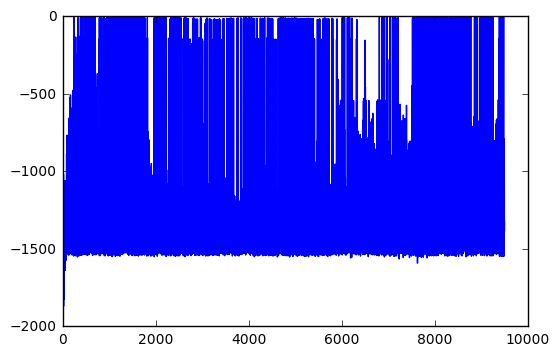

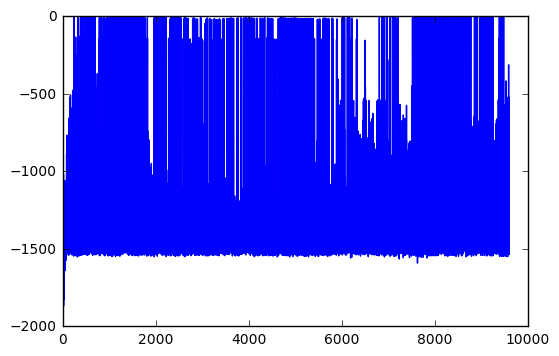

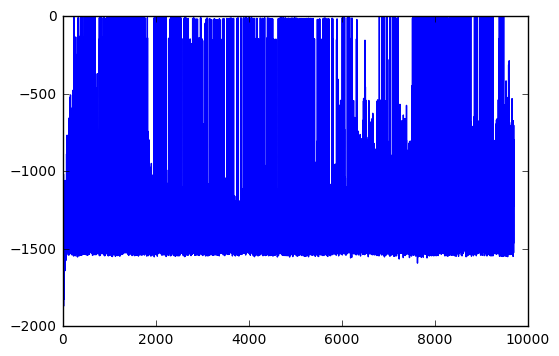

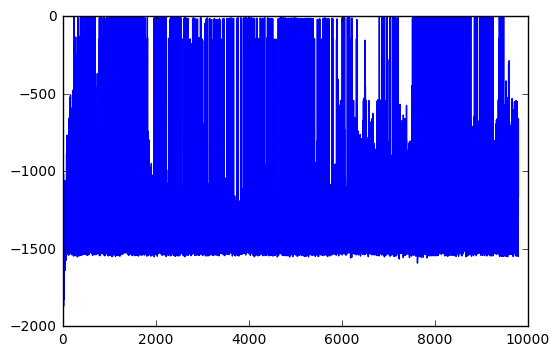

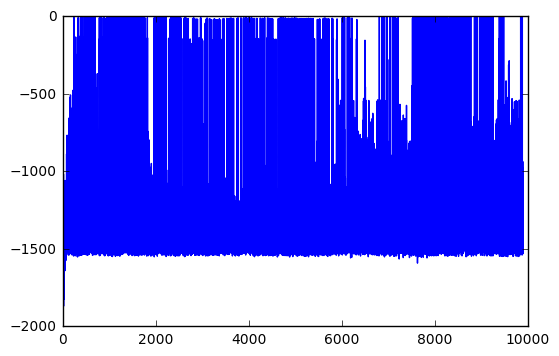

In [2]:
# Init tensorflow
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
env = gym.make('Pendulum-v0')
gamma = 0.9
loss_log = []
action_log = []
rsum_log = [0]

for episode in range(10000):
    s = env.reset()
    rsum = 0
    for step in range(200):
        #mu = sess.run(tf_mu, feed_dict={tf_obs_a:[s]})[0]
        #action = saturation(np.random.normal(mu, sigma, 1))
        action = sess.run(tf_out_action, feed_dict={tf_obs_a:[s]})
        action_log.append(action)
        s1, r, d, info = env.step([action])
        rsum += r
        
        # Training
        # critic network
        v1 = sess.run(tf_v, feed_dict={tf_obs_c:[s1]})
        v = sess.run(tf_v, feed_dict={tf_obs_c:[s]})
        target_v = r + gamma * v1
        _, loss = sess.run([trainer_c, loss_c], feed_dict={tf_obs_c:[s], tf_target_v:np.array([[target_v]])})
        # actor network
        td_error = target_v - v
        sess.run(trainer_a, feed_dict={tf_obs_a:[s], 
                                       tf_action:action,
                                       tf_advantage:td_error})
        if d: break
        s = s1
    #print 'episode', episode, 'rsum', rsum
    rsum_log.append(rsum)
    if episode % 100 == 0:
        plt.plot(rsum_log)
        plt.show()

In [6]:
env = gym.make('Pendulum-v0')
for episode in range(10):
    s = env.reset()
    rsum = 0
    for step in range(200):
        action = sess.run(tf_out_action, feed_dict={tf_obs_a:[s]})
        s, r, d, info = env.step([action])
        rsum += r
        env.render()
        if d: break
    print rsum


[2017-07-14 14:05:31,577] Making new env: Pendulum-v0


-1525.60278265
-1342.90088818
-18.060368841
-1206.35933449
-1198.59710067
-17.8722284823
-17.3362600224
-1230.92058167
-1508.86766524
-1502.48865369
